In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

# Named Entity Recognition (NER)

NER is an information extraction technique to identify and classify named entities in text. These entities can be pre-defined and generic like location names, organizations, time and etc, or they can be very specific like the example with the resume.

The goal of a named entity recognition (NER) system is to identify all textual mentions of the named entities. This can be broken down into two sub-tasks: identifying the boundaries of the NE, and identifying its type.

Named entity recognition is a task that is well-suited to the type of classifier-based approach. In particular, a tagger can be built that labels each word in a sentence using the IOB format, where chunks are labelled by their appropriate type.

The IOB Tagging system contains tags of the form:

* B - {CHUNK_TYPE} – for the word in the Beginning chunk
* I - {CHUNK_TYPE} – for words Inside the chunk
* O – Outside any chunk

The IOB tags are further classified into the following classes –

* geo = Geographical Entity
* org = Organization
* per = Person
* gpe = Geopolitical Entity
* tim = Time indicator
* art = Artifact
* eve = Event
* nat = Natural Phenomenon

## Approaches to NER
* **Classical Approaches:** mostly rule-based.
* **Machine Learning Approaches:** there are two main methods in this category: 
    * Treat the problem as a multi-class classification where named entities are our labels so we can apply different classification algorithms. The problem here is that identifying and labeling named entities require thorough understanding of the context of a sentence and sequence of the word labels in it, which this method ignores that.
    * Conditional Random Field (CRF) model. It is a probabilistic graphical model that can be used to model sequential data such as labels of words in a sentence. The CRF model is able to capture the features of the current and previous labels in a sequence but it cannot understand the context of the forward labels; this shortcoming plus the extra feature engineering involved with training a CRF model, makes it less appealing to be adapted by the industry.
* **Deep Learning Approaches:** Bidirectional RNNs, Transformers

# EDA

In [55]:
data = pd.read_csv("ner.csv", encoding = "ISO-8859-1", on_bad_lines='warn',usecols=['sentence_idx', 'word', 'tag'])
data = data[data['sentence_idx'] != 'prev-lemma'].dropna(subset=['sentence_idx']).reset_index(drop=True)
print(data.shape)
# data.head()
data.describe()

C:\Users\Sachit\AppData\Local\Temp\ipykernel_6056\43388635.py:1: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("ner.csv", encoding = "ISO-8859-1", on_bad_lines='warn',usecols=['sentence_idx', 'word', 'tag'])


(1050794, 3)


,sentence_idx,word,tag
count,1050794,1050783,1050794
unique,36684,30171,17
top,2549,the,O
freq,140,52799,889973


**Create list of list of tuples to differentiate each sentence from each other**

In [18]:
class SentenceGetter(object):
    def __init__(self, dataset, word_col, tag_col, sent_id_col):
        self.n_sent = 1
        self.dataset = dataset
        self.empty = False
        agg_func = lambda s: [(w, t) for w,t in zip(s[word_col].values.tolist(), s[tag_col].values.tolist())]
        self.grouped = self.dataset.groupby(sent_id_col).apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    # def get_next(self):
        # try:
            # s = self.grouped["Sentence: {}".format(self.n_sent)]
            # self.n_sent += 1
            # return s
        # except:
            # return None

In [19]:
getter = SentenceGetter(dataset=data, word_col='word', tag_col='tag', sent_id_col='sentence_idx')
sentences = getter.sentences
print(sentences[0])

[('Thousands', 'O'), ('of', 'O'), ('demonstrators', 'O'), ('have', 'O'), ('marched', 'O'), ('through', 'O'), ('London', 'B-geo'), ('to', 'O'), ('protest', 'O'), ('the', 'O'), ('war', 'O'), ('in', 'O'), ('Iraq', 'B-geo'), ('and', 'O'), ('demand', 'O'), ('the', 'O'), ('withdrawal', 'O'), ('of', 'O'), ('British', 'B-gpe'), ('troops', 'O'), ('from', 'O'), ('that', 'O'), ('country', 'O'), ('.', 'O')]


Number of Sentences: 36684
Maximum sequence length: 140
Number of unique words: 30173


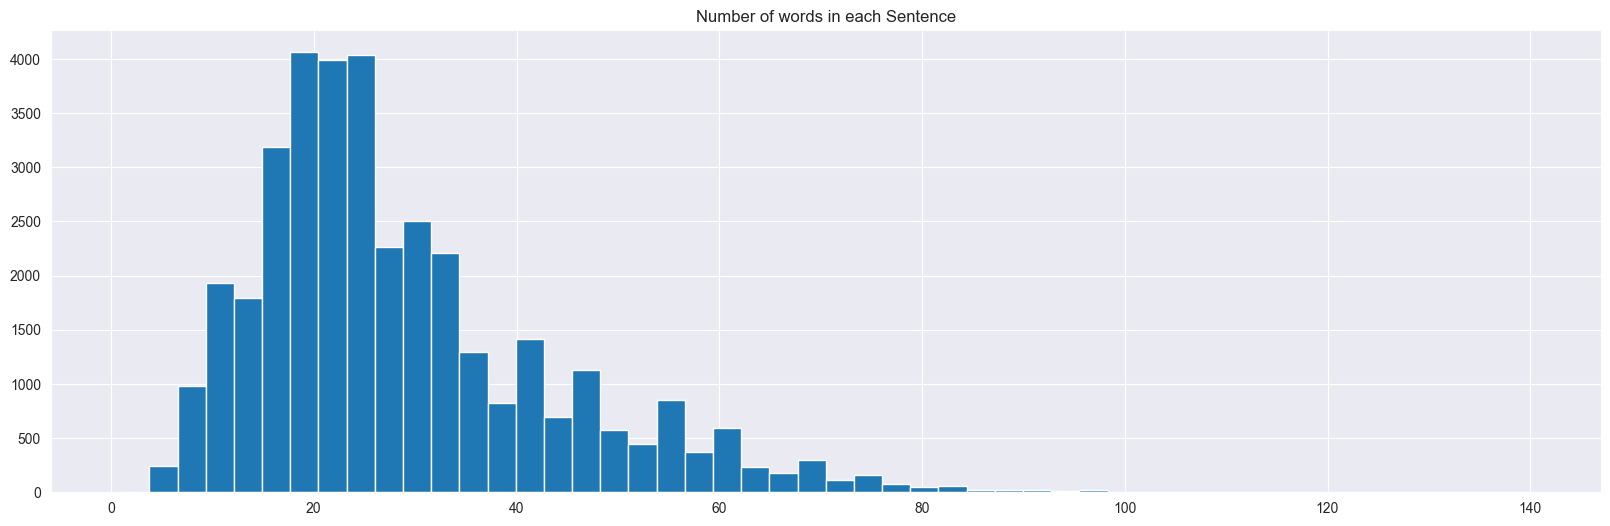

In [20]:
fig, ax = plt.subplots(figsize=(20, 6))
ax.hist([len(s) for s in sentences], bins=50)
ax.set_title('Number of words in each Sentence')

maxlen = max([len(s) for s in sentences])
print('Number of Sentences:', len(sentences))
print ('Maximum sequence length:', maxlen)

words = list(set(data["word"].values))
words.append("ENDPAD")
n_words = len(words)
print('Number of unique words:', n_words)

Number of unique Tags: 17


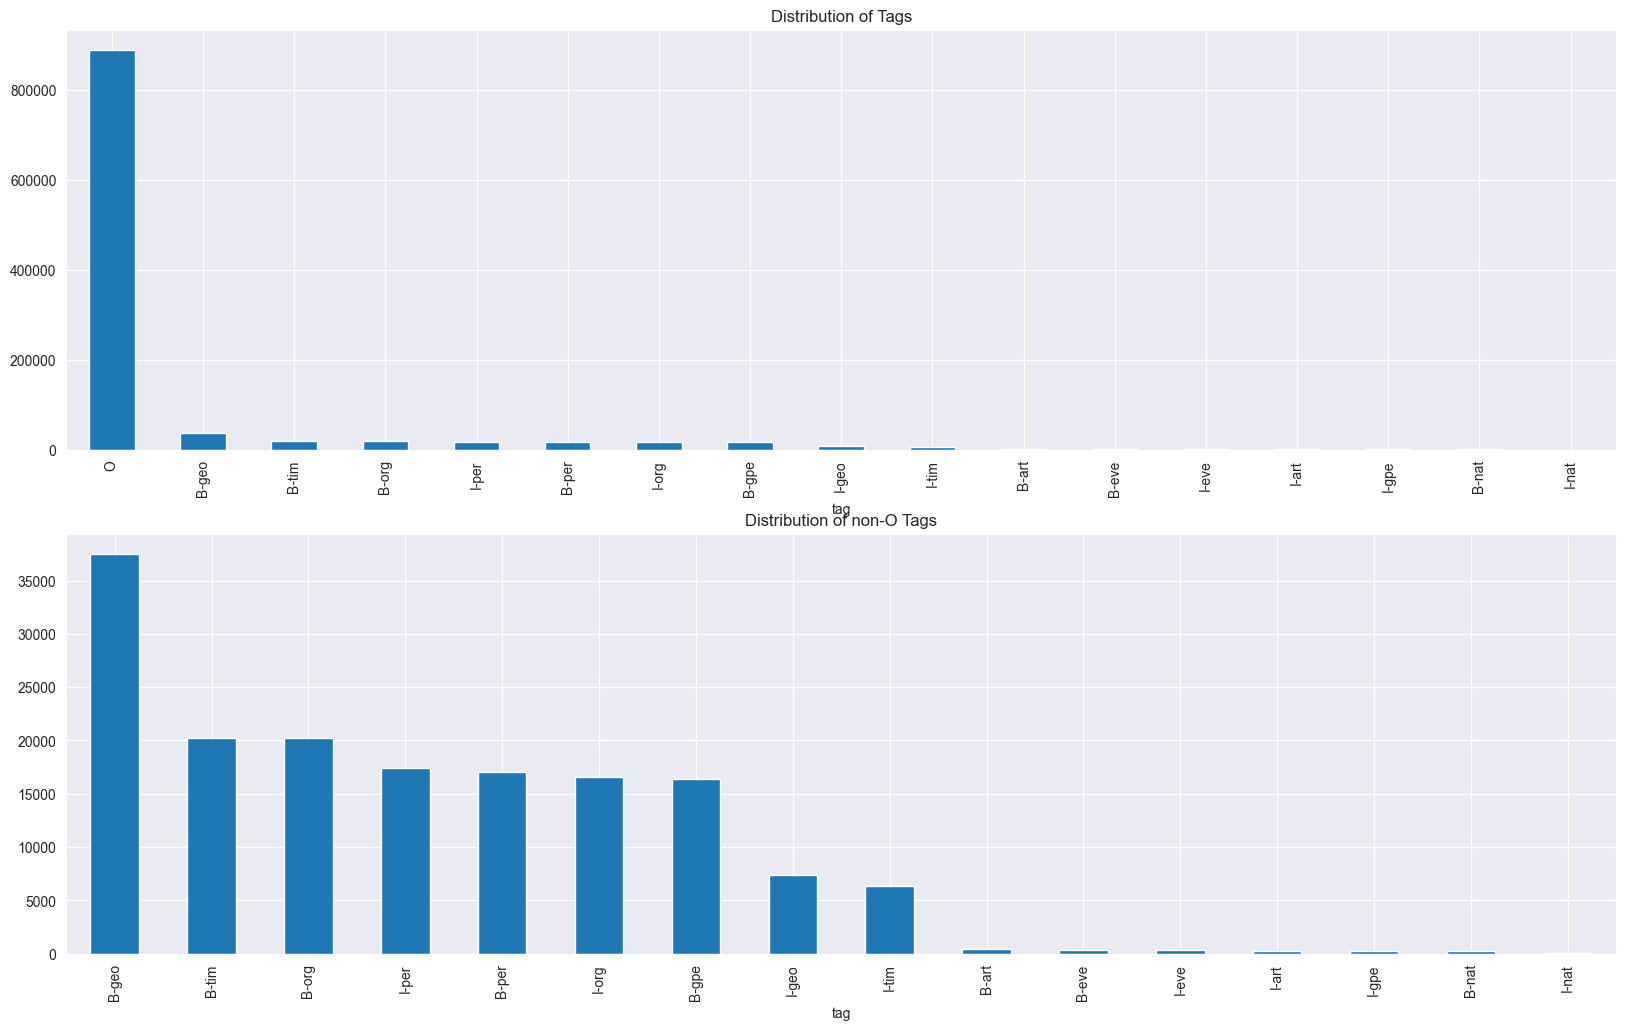

In [21]:
fig, ax = plt.subplots(2, 1, figsize=(20, 12))
data.tag.value_counts().plot.bar(ax=ax[0], title='Distribution of Tags')
data[data.tag != 'O'].tag.value_counts().plot.bar(ax=ax[1], title='Distribution of non-O Tags')

tags = list(set(data["tag"].values))
n_tags = len(tags)
print('Number of unique Tags:', n_tags)

**Converting words to numbers and numbers to words**

In [22]:
word2idx = {w: i for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

# Modelling

In [23]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model, to_categorical

In [24]:
X = [[word2idx[w[0]] for w in s] for s in sentences]
X = sequence.pad_sequences(maxlen=maxlen, sequences=X, padding="post",value=n_words - 1)

y = [[tag2idx[w[1]] for w in s] for s in sentences]
y = sequence.pad_sequences(maxlen=maxlen, sequences=y, padding="post", value=tag2idx["O"])
y = np.array([to_categorical(i, num_classes=n_tags) for i in y])

print('X shape', X.shape, 'y shape', y.shape)

X shape (36684, 140) y shape (36684, 140, 17)


In [25]:
EMBEDDING_VECTOR_LENGTH = 50
DENSE_DIM = 32
NUM_HEADS = 2    

In [26]:
class PositionalEmbedding(tf.keras.layers.Layer):
    def __init__(self, sequence_length, input_dim, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = tf.keras.layers.Embedding(input_dim, output_dim)
        self.position_embeddings = tf.keras.layers.Embedding(sequence_length, output_dim)
        self.sequence_length = sequence_length
        self.input_dim = input_dim
        self.output_dim = output_dim
        
    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions
        
    def get_config(self):
        config = super().get_config()
        config.update({
            "output_dim": self.output_dim,
            "sequence_length": self.sequence_length,
            "input_dim": self.input_dim,
        })
        return config
    
class TransformerEncoder(tf.keras.layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential([tf.keras.layers.Dense(dense_dim, activation='relu'), tf.keras.layers.Dense(embed_dim)])
        self.layernorm1 = tf.keras.layers.LayerNormalization()
        self.layernorm2 = tf.keras.layers.LayerNormalization()
    
    def call(self, inputs, mask=None):
        if mask is not None:
            mask = mask[: tf.newaxis, :]
        attention_output = self.attention(inputs, inputs, attention_mask=mask)
        proj_input = self.layernorm1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm2(proj_input + proj_output)
    
    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim
        })
        return config    

**Lets define our model**

A token classification is pretty simple and similar to that of sequence classification, ie there is only one change, since we need predictions for each input tokken we do not use the Global Pooling Layer, therefore the architechture looks something like:
* Input Layer
* Embeddings
* Transformer Encoder Block
* Dropout (optional)
* Classification Layer (where n_units = number of classes)



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None)]            0         
                                                                 
 positional_embedding (Posi  (None, None, 50)          1515650   
 tionalEmbedding)                                                
                                                                 
 transformer_encoder (Trans  (None, None, 50)          23832     
 formerEncoder)                                                  
                                                                 
 dropout (Dropout)           (None, None, 50)          0         
                                                                 
 dense_2 (Dense)             (None, None, 17)          867       
                                                                 
Total params: 1540349 (5.88 MB)
Trainable params: 1540349 (

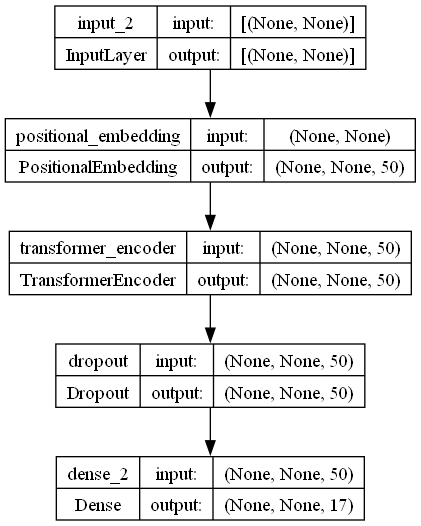

In [27]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=7)
rlp = ReduceLROnPlateau(monitor='loss', patience=3, verbose=1)

inputs = keras.Input(shape=(None, ), dtype="int64")
x = PositionalEmbedding(maxlen, n_words, EMBEDDING_VECTOR_LENGTH)(inputs)
x = TransformerEncoder(EMBEDDING_VECTOR_LENGTH, DENSE_DIM, NUM_HEADS)(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(n_tags, activation='softmax')(x)

model = keras.Model(inputs, outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()
plot_model(model, show_shapes=True)

In [33]:
history = model.fit(x=X, y=y, validation_split=0.1, callbacks=[es, rlp], epochs=10)

Epoch 1/10


1032/1032 [==============================] - 92s 79ms/step - loss: 0.0866 - accuracy: 0.9804 - val_loss: 0.0307 - val_accuracy: 0.9915 - lr: 0.0010
Epoch 2/10
1032/1032 [==============================] - 70s 67ms/step - loss: 0.0378 - accuracy: 0.9895 - val_loss: 0.0278 - val_accuracy: 0.9921 - lr: 0.0010
Epoch 3/10
1032/1032 [==============================] - 76s 73ms/step - loss: 0.0313 - accuracy: 0.9909 - val_loss: 0.0263 - val_accuracy: 0.9925 - lr: 0.0010
Epoch 4/10
1032/1032 [==============================] - 96s 93ms/step - loss: 0.0276 - accuracy: 0.9917 - val_loss: 0.0262 - val_accuracy: 0.9927 - lr: 0.0010
Epoch 5/10
1032/1032 [==============================] - 73s 71ms/step - loss: 0.0243 - accuracy: 0.9924 - val_loss: 0.0258 - val_accuracy: 0.9929 - lr: 0.0010
Epoch 6/10
1032/1032 [==============================] - 65s 63ms/step - loss: 0.0211 - accuracy: 0.9932 - val_loss: 0.0272 - val_accuracy: 0.9931 - lr: 0.0010
Epoch 7/10
1032/1032 [======================

Text(0.5, 0.98, 'Model Metrics')

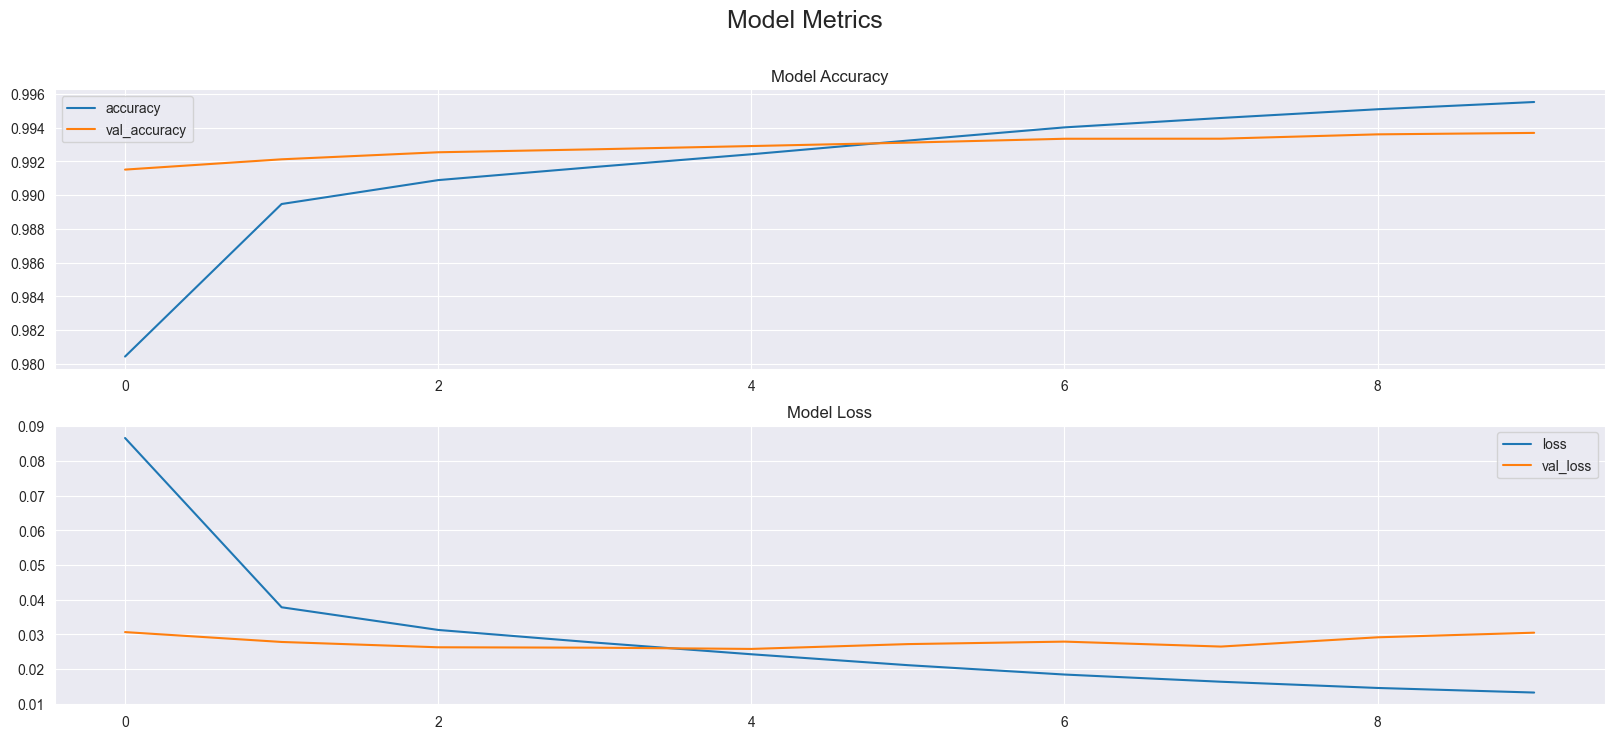

In [34]:
fig, ax = plt.subplots(2, 1, figsize=(20, 8))
df = pd.DataFrame(history.history)
df[['accuracy', 'val_accuracy']].plot(ax=ax[0])
df[['loss', 'val_loss']].plot(ax=ax[1])
ax[0].set_title('Model Accuracy', fontsize=12)
ax[1].set_title('Model Loss', fontsize=12)
fig.suptitle('Model Metrics', fontsize=18)

In [53]:
i = np.random.randint(0, X.shape[0])
p = model.predict(np.array([X[i]]))
p = np.argmax(p, axis=-1)
y_true = np.argmax(y, axis=-1)[i]
text = ""
for w in X[i]:
    text += words[w] +" "
print(text)
print(f"{'Word':15}{'True':5}\t{'Pred'}")
print("-"*30)
for (w, t, pred) in zip(X[i], y_true, p[0]):
    print(f"{words[w]:15}{tags[t]}\t{tags[pred]}")
    if words[w] == 'ENDPAD': 
        break

1/1 [==============================] - 0s 53ms/step
Djibouti military and diplomatic sources say the fighting began Tuesday in the northern Mount Gabla area . ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD E

'So far , nearly 100 militants have been reported killed in the region since Thursday . ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD '

In [49]:
# text = "The American Civil War was a civil war in the United States between the Union"
text = "When Sebastian Thrun started working on self-driving cars at Google in 2007, few people outside of the company took him seriously."
sent = []
sentList = text.split()
for w in sentList:
    if w not in words:
        sent.append(word2idx['the'])
    else:
        sent.append(word2idx[w])
sent = sequence.pad_sequences(maxlen=maxlen, sequences=[sent], padding="post",value=n_words - 1)
ans = model.predict(sent)
j = 0
for i in range(len(sentList)):
    print(f"{sentList[i]:15}, {tags[np.argmax(ans[0][i])]}, ")
    # print(f"{sentList[i]}\t{tags[]}")

1/1 [==============================] - 0s 42ms/step
When           , O, 
Sebastian      , O, 
Thrun          , O, 
started        , O, 
working        , O, 
on             , O, 
self-driving   , O, 
cars           , O, 
at             , O, 
Google         , B-org, 
in             , O, 
2007,          , O, 
few            , O, 
people         , O, 
outside        , O, 
of             , O, 
the            , O, 
company        , O, 
took           , O, 
him            , O, 
seriously.     , O, 
